In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Pacific_Extent = pd.read_excel(filepath, sheet_name='Pacific-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Pacific_Extent)
fp.date_time(Pacific_Extent)

,Extent,Date
0,668714.275,1979-01-01
1,566930.458,1979-02-01
2,688420.115,1979-03-01
3,859963.043,1979-04-01
4,1127120.160,1979-05-01
...,...,...
533,1134056.102,2023-06-01
534,1484824.377,2023-07-01
535,1671324.717,2023-08-01
536,1726376.097,2023-09-01


In [5]:
scaler = MinMaxScaler()
Pacific_Extent['Extent'] = scaler.fit_transform(Pacific_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 3
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Pacific_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((524, 12, 1), (524,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Pacific_model_LT3/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 217ms/step - loss: 0.2235 - root_mean_squared_error: 0.4728 - val_loss: 0.1554 - val_root_mean_squared_error: 0.3943
Epoch 2/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0875 - root_mean_squared_error: 0.2959 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1942
Epoch 3/50
53/53 [==============================] - 11s 214ms/step - loss: 0.0394 - root_mean_squared_error: 0.1985 - val_loss: 0.0307 - val_root_mean_squared_error: 0.1753
Epoch 4/50
53/53 [==============================] - 11s 217ms/step - loss: 0.0326 - root_mean_squared_error: 0.1804 - val_loss: 0.0232 - val_root_mean_squared_error: 0.1523
Epoch 5/50
53/53 [==============================] - 12s 232ms/step - loss: 0.0249 - root_mean_squared_error: 0.1577 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1252
Epoch 6/50
53/53 [==============================] - 12s 229ms/step - loss: 0.0204 - root_mean_squared_error: 0.1427 - val_loss: 0.0131 

Epoch 32/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0822
Epoch 33/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0099 - root_mean_squared_error: 0.0996 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0716
Epoch 34/50
53/53 [==============================] - 13s 250ms/step - loss: 0.0094 - root_mean_squared_error: 0.0971 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0689
Epoch 35/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0090 - root_mean_squared_error: 0.0946 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0729
Epoch 36/50
53/53 [==============================] - 2s 35ms/step - loss: 0.0093 - root_mean_squared_error: 0.0962 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0714
Epoch 37/50
53/53 [==============================] - 2s 35ms/step - loss: 0.0090 - root_mean_squared_error: 0.0948 - val_loss: 0.0066 - va

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

6.189984889825185 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

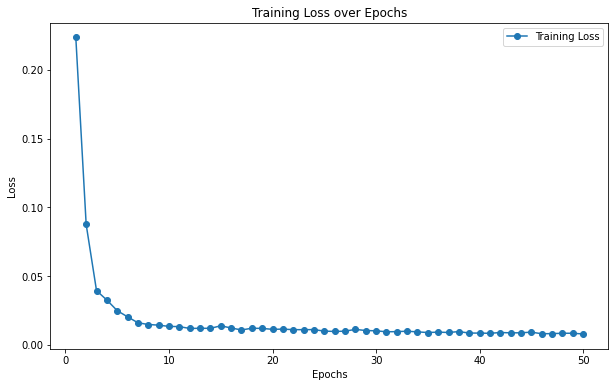

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

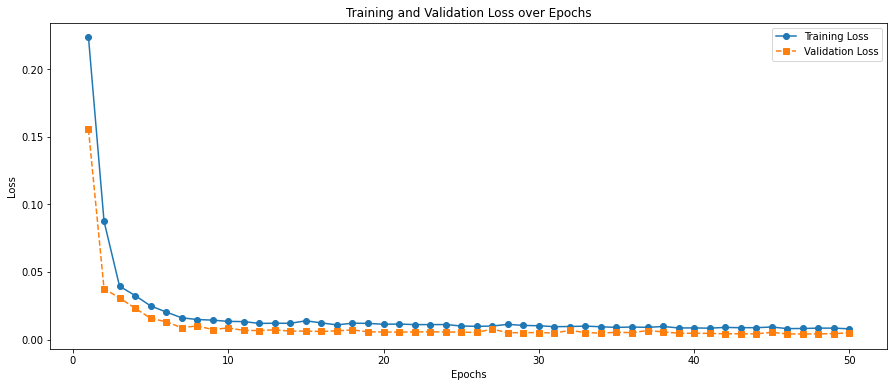

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Pacific_model_LT3/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 14ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.06792225335258559
MAE : 0.055952159002805577


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.599750e+06,1701391.499
1,1.734149e+06,1890231.668
2,1.747148e+06,2203401.829
3,1.613154e+06,1960480.542
4,1.272810e+06,1264318.504
5,7.924190e+05,863206.294
6,4.207495e+05,635624.004
7,3.432455e+05,460009.672
8,4.428835e+05,610848.036
9,6.696062e+05,819257.445


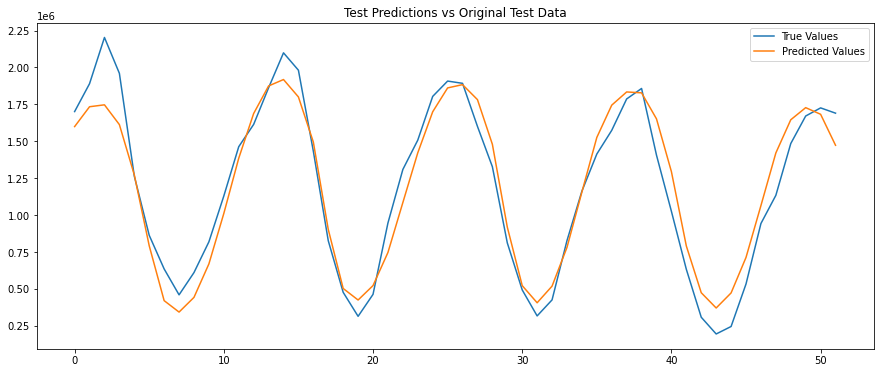

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 17ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

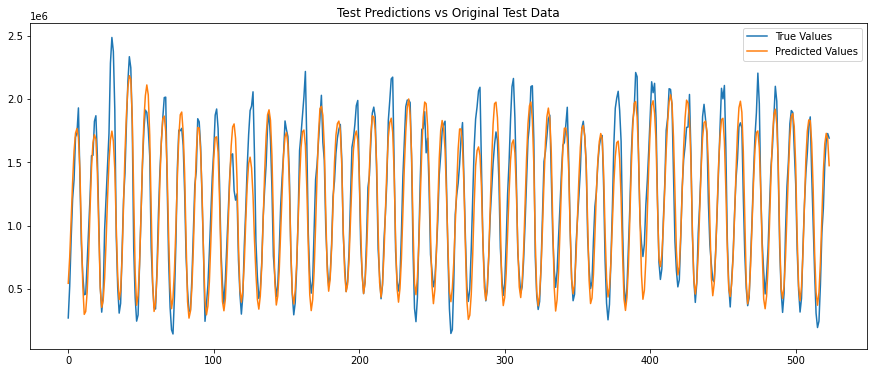

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()